In [ ]:
import tonic.datasets as datasets
import tonic.transforms as transforms
from snn_delays.config import DATASET_PATH
import numpy as np
import torch

PATH = DATASET_PATH

### event transform: downsample
downsample = transforms.Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None)

### frame transforms
frame_transform = transforms.ToFrame(sensor_size=(17, 17, 2), n_time_bins=50,  overlap=0)
target_transform = transforms.ToOneHotEncoding(n_classes=10)

## events from test set of n-mnist
nmnist = datasets.NMNIST(save_to=PATH, train=False, first_saccade_only=True)

# get indexes per class
class_indices = {}
for idx, (_, label) in enumerate(nmnist):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

# how many samples per class from 0-9
for x in range(10):
    print(len(class_indices[x]))


980
1135
1032
1010
982
892
958
1028
974
1009


Downsampled events and convert to frames

In [44]:
from torch.utils.data import Subset, DataLoader, TensorDataset

class_indices = dict(sorted(class_indices.items()))
sampled_indices = [np.random.choice(indices) for indices in class_indices.values()]

frames = torch.zeros(10, 50, 2, 17, 17) 
onehot_labels = torch.zeros(10, 10)

downsampled_events = []

import torch
for i, idx in enumerate(sampled_indices):
    raw_events, raw_label = nmnist[idx]
    downsampled_events.append(downsample(raw_events))
    frames[i] = torch.from_numpy(frame_transform(downsampled_events[-1]))
    onehot_labels[i] = torch.from_numpy(target_transform(raw_label))

### Save downsampled events

Each element of downsampled_events is a Tuple (list_of_events, class), where each event in list_of_events is Tuple (x, y, timestamp, polarity)

In [46]:
downsampled_events[7]

array([(12,  7,  1381, 1), ( 8,  9,  2490, 0), ( 0, 16,  2503, 1), ...,
       (15, 14, 98804, 1), ( 7,  6, 99098, 0), (10,  7, 99264, 0)],
      dtype=[('x', '<i4'), ('y', '<i4'), ('t', '<i4'), ('p', '<i4')])

In [55]:
# some stats
for events in downsampled_events:
    print(f'{len(events)} events from {events[0][2]} to {events[-1][2]} us')

1347 events from 2687 to 99793 us
622 events from 1555 to 99519 us
1311 events from 258 to 99804 us
1744 events from 7 to 99933 us
810 events from 2371 to 99553 us
1428 events from 566 to 99813 us
2258 events from 344 to 99705 us
1393 events from 1381 to 99264 us
1585 events from 114 to 99737 us
1254 events from 2061 to 97155 us


In [ ]:
# save
np.savez('events.npz', *downsampled_events)

In [ ]:
#load
file = np.load('events.npz')

# check file keys 
print(file.keys())

# display the array corresponding to number 7
print(file['arr_7'])

KeysView(NpzFile 'events.npz' with keys: arr_0, arr_1, arr_2, arr_3, arr_4...)
[(12,  7,  1381, 1) ( 8,  9,  2490, 0) ( 0, 16,  2503, 1) ...
 (15, 14, 98804, 1) ( 7,  6, 99098, 0) (10,  7, 99264, 0)]


Create dataset from frames

In [41]:
import torch
print(frames.shape)
print(onehot_labels.shape)
dataset = TensorDataset(frames, onehot_labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

torch.Size([10, 50, 2, 17, 17])
torch.Size([10, 10])


Inference from frames

In [ ]:
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.visualization_utils import plot_param
from snn_delays.snn import SNN
import matplotlib.pyplot as plt

model_name = 'binary_nmnist50_l1_1d1.t7_9232_max_56epoch'
ckpt_dir = 'exp_snn2chip_nmnist'
snn = ModelLoader(model_name, ckpt_dir, 10, 'cuda', True)
snn.total_time = snn.win

aa, bb = snn.test(dataloader, only_one_batch=True)



[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
None
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
Instance of <class 'snn_delays.experimental_models.snn_binary.BinarySNN'> loaded successfully
Test Loss: 0.037487152963876724
Avg spk_count per neuron for all 50 time-steps 20.053125381469727
Avg spk per neuron per layer [20.053125]
Test Accuracy of the model on the test samples: 100.000



2D Visualization of inputs (sum across 50 timesteps and 2 channels)

torch.Size([10, 50, 2, 17, 17])
torch.Size([10, 17, 17])


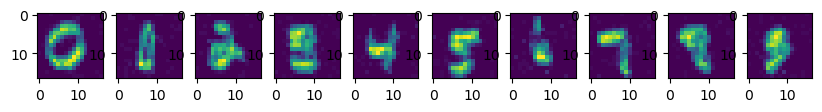

In [38]:
img_frames = torch.sum(frames, dim=(1, 2))
print(frames.shape)
print(img_frames.shape)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(img_frames[i, :, :])

Text(0.5, 1.0, 'membrane potentials')

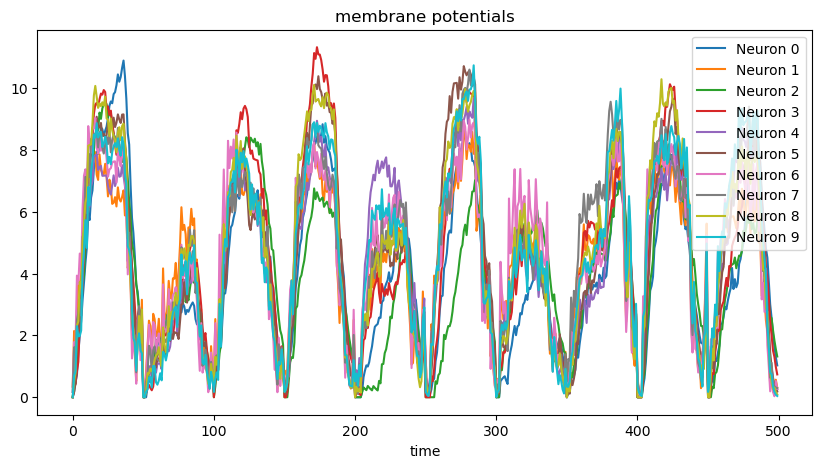

In [19]:
mem_output = snn.mem_state['output']
mems_out = mem_output[:, :10, :].permute(1, 0, 2).reshape(500, 10)
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(mems_out.cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('membrane potentials')

Text(0.5, 1.0, 'softmax of membrane potentials')

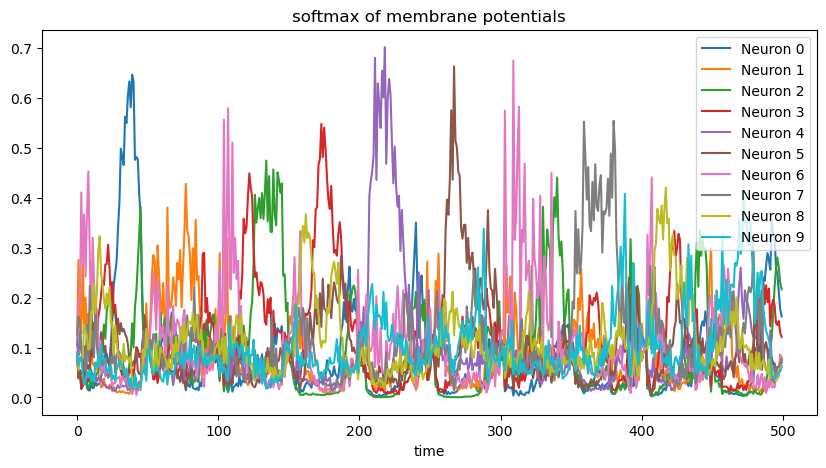

In [20]:
import torch.nn.functional as F
soft_mems = F.softmax(snn.mem_state['output'][:, :10, :], dim=2).permute(1, 0, 2).reshape(500, 10)
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(soft_mems.detach().cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('softmax of membrane potentials')

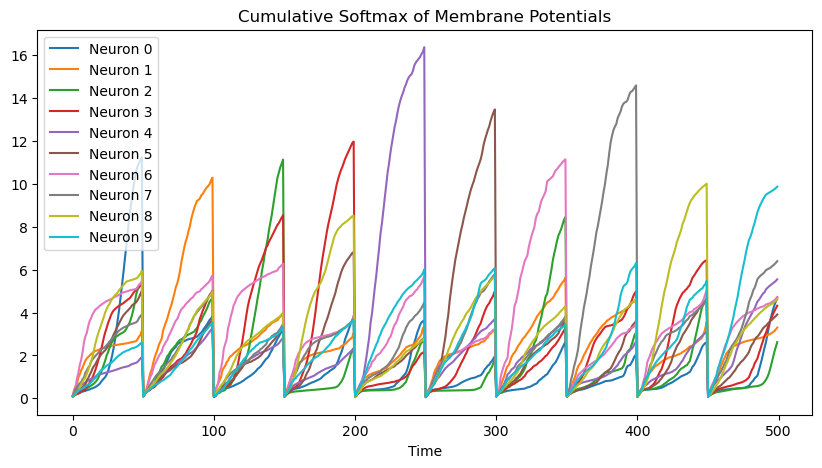

In [21]:
# Apply softmax to the first 10 neurons' membrane potentials
soft_mems = F.softmax(snn.mem_state['output'][:, :10, :], dim=2)
soft_mems_cumulative = torch.cumsum(soft_mems, dim=0)
soft_mems_cumulative = soft_mems_cumulative.permute(1, 0, 2).reshape(500, 10)

# Plot the cumulative softmax membrane potentials
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(soft_mems_cumulative.detach().cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
plt.legend()
plt.xlabel('Time')
plt.title('Cumulative Softmax of Membrane Potentials')
plt.show()

Winner neuron behaves as expected, from 0 to 9 :)